# Using the single threaded ClusterFinder

This is an old example on how to use the single threaded ClusterFinder. You probably want to use: ClusterFinderMT

In [1]:
#add the dev version of aare
import sys; sys.path.append('/home/l_msdetect/erik/aare/build')
from helpers import nb_aare_version
nb_aare_version()

#Our normal python imports
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import boost_histogram as bh
import time

#Directly import what we need from aare
from aare import File, ClusterFinder, ClusterFile, hitmap
from aare._aare import calculate_eta2

base = Path('/mnt/sls_det_storage/matterhorn_data/aare_test_data/')

Example run on: **2025-04-23 09:19** with aare: **dev**

### Read initial pedestal

- First step is to set up the pedestal
- Note! this particular sensor has some radiation damage

In [2]:
#In this example we set up the pedestal using the beginning of the file
#Better would of course be a dedicated dark measurement
f = File(base/'Moench03new/cu_half_speed_master_4.json')

n_frames_pd = 1000
cluster_size = (3,3)
image_size = (f.rows, f.cols)

#Read n_frames_pd from f and use them to calculate the 
#initial pedestal
t0 = time.perf_counter()
cf = ClusterFinder(image_size, cluster_size, capacity = 3000000)
print(f'{cf=}')
for i in range(n_frames_pd):
    img = f.read_frame()
    cf.push_pedestal_frame(img)
elapsed_t = time.perf_counter()-t0
print(f'Pedestal took: {elapsed_t:.3f}s')

cf=<aare._aare.ClusterFinder_Cluster3x3i object at 0x7fc889c9c7f0>
Pedestal took: 1.359s


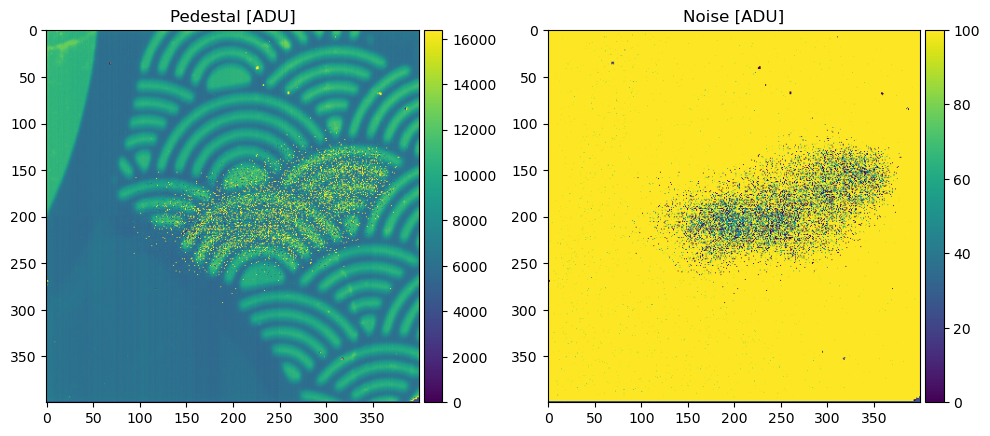

In [3]:
#plot the pedestal including colorbar
fig, ax = plt.subplots(1,2, figsize = (10,5))
im = ax[0].imshow(cf.pedestal)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax[0].set_title('Pedestal [ADU]');

im = ax[1].imshow(cf.noise)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
im.set_clim(0,100)
ax[1].set_title('Noise [ADU]');
fig.tight_layout()

### Run clustering on N frames

- Now we use the next N frames to find clusters

In [4]:
N = 2000
t0 = time.perf_counter()
hist1 = bh.Histogram(bh.axis.Regular(40, -2, 4000))

#Not needed, just here for reproducibility when executing the cell over and over
f.seek(n_frames_pd) 

#Read N frames from the file
t0 = time.perf_counter()
data = f.read_n(N)
t_elapsed = time.perf_counter()-t0
print(f'Reading {N} frames took {t_elapsed:.3f}s {N/t_elapsed:.0f} FPS, {f.bytes_per_frame*N/1024**2:.3f} GB/s')

#Run clustering on all frames in data
t0 = time.perf_counter()
for frame in data:
    cf.find_clusters(frame)
t_elapsed = time.perf_counter()-t0
print(f'Clustering {N} frames took {t_elapsed:.2f}s  {N/t_elapsed:.0f} FPS')

#Fill a boost-histogram with the sum of each cluster
t0 = time.perf_counter()
clusters = cf.steal_clusters(realloc_same_capacity=False)
hist1.fill(clusters.sum())
t_elapsed = time.perf_counter()-t0
print(f'Filling histogram with the sum of {clusters.size} clusters took: {t_elapsed:.3f}s, {clusters.size/t_elapsed:.3g} clust/s')
print(f'Average number of clusters per frame {clusters.size/N:.3f}')

Reading 2000 frames took 0.087s 23045 FPS, 610.352 GB/s
Clustering 2000 frames took 6.58s  304 FPS
Filling histogram with the sum of 2679550 clusters took: 0.137s, 1.95e+07 clust/s
Average number of clusters per frame 1339.775


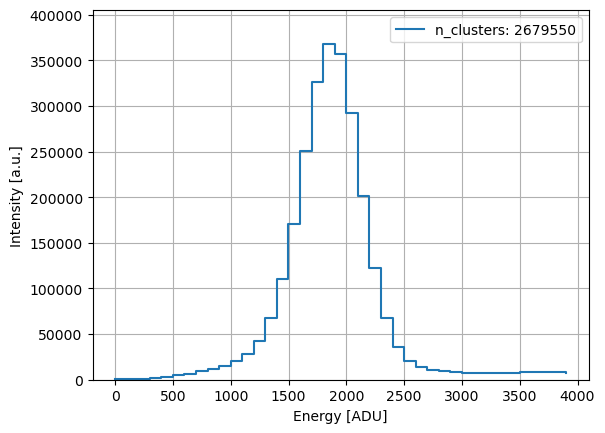

In [5]:
#plot the histogram
fig, ax = plt.subplots()
ax.step(hist1.axes[0].edges[:-1], hist1.values(), where="post", label = f'n_clusters: {clusters.size}');
ax.set_xlabel('Energy [ADU]')
ax.set_ylabel('Intensity [a.u.]')
ax.legend()
ax.set_ylim(0, hist1.values().max()*1.1)
ax.grid()

Filling hitmap took: 0.008s 3.39e+08 hits/s


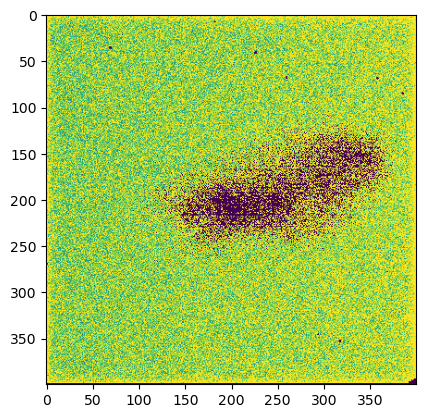

In [6]:
t0 = time.perf_counter()
img = hitmap((400,400), clusters)
elapsed_t = time.perf_counter()-t0
print(f'Filling hitmap took: {elapsed_t:.3f}s {clusters.size/elapsed_t:.3g} hits/s')

fig, ax = plt.subplots()
im = ax.imshow(img)
im.set_clim(0,20)

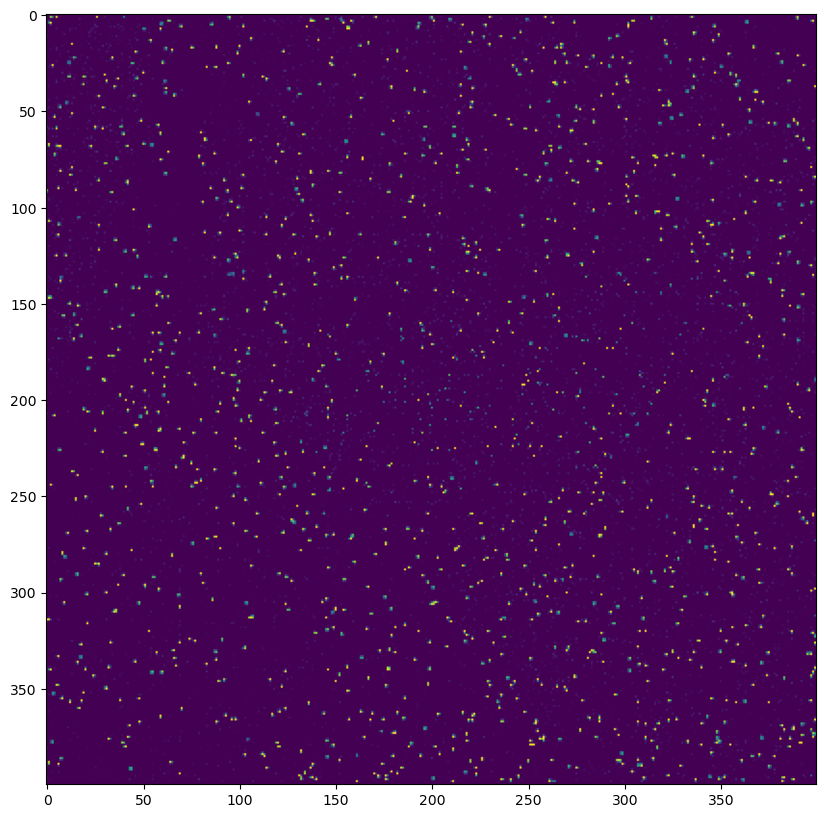

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(data[0]-cf.pedestal)
im.set_clim(100,1000)

## Calculate ETA

In [8]:
t0 = time.perf_counter()
eta2 = calculate_eta2(clusters)
elapsed_t = time.perf_counter()-t0
print(f'Calcualting eta2 took: {elapsed_t:.3f}s, {clusters.size/elapsed_t:.3g} clusters/s')

Calcualting eta2 took: 0.060s, 4.44e+07 clusters/s


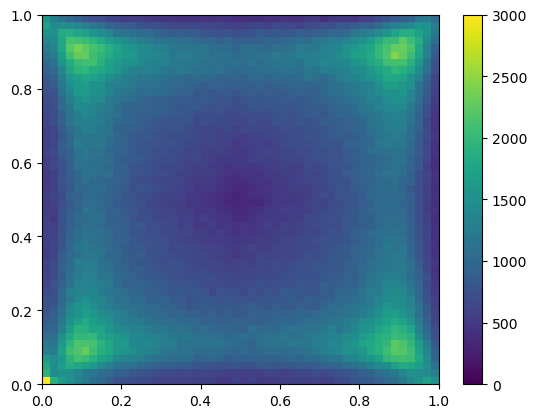

In [9]:
hist = bh.Histogram(bh.axis.Regular(50, 0, 1), bh.axis.Regular(50, 0, 1))
hist.fill(eta2[:,0], eta2[:,1])
fig, ax = plt.subplots()
mesh = ax.pcolormesh(*hist.axes.edges.T, hist.view())
fig.colorbar(mesh)
mesh.set_clim(0,.3e4)

## Writing ClusterFiles from python

In [10]:
# #Not needed, just here for reproducibility when executing the cell over and over
# f.seek(n_frames_pd) 
# n_frames = 5

# with ClusterFile(base/'Moench03new/test.clust', mode = 'w') as cluster_file:
#     for i in range(n_frames):
#         frame_number = f.frame_number()
#         cf.find_clusters(f.read_frame())
#         clusters = cf.steal_clusters()
#         clusters.frame_number = frame_number
#         print(f'Found {clusters.size} clusters in frame {frame_number}')
#         cluster_file.write_frame(clusters)


## Read the clusters back to double check

In [11]:
# hist1 = bh.Histogram(bh.axis.Regular(40, -2, 4000))

# with ClusterFile(base/'Moench03new/test.clust') as cluster_file:
#     #Not possible to know the number of frames without 
#     #looping on the old cluster file
#     for i in range(n_frames): 
#         clusters = cluster_file.read_frame()
#         print(f'Read {clusters.size} clusters from frame {clusters.frame_number}')
#         hist1.fill(clusters.sum())
        
# fig, ax = plt.subplots()
# ax.step(hist1.axes[0].edges[:-1], hist1.values(), where="post", label = f'n_clusters: {clusters.size}');
# ax.set_xlabel('Energy [ADU]')
# ax.set_ylabel('Intensity [a.u.]');
# ax.legend()
# ax.set_ylim(0, hist1.values().max()*1.1)
# ax.grid()